This notebook is for the third model, which only takes in one zoom level as input (magnification 3), and performs data augmentation on the training set (rotates 90, 180, and 270 degrees). We can compare this with our other combined model to see which performs better.

In [1]:
# Install the OpenSlide C library and Python bindings
# After installing these libraries, use `Runtime -> restart and run all` on the menu
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
openslide-tools is already the newest version (3.4.1+dfsg-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
import shutil
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split
from skimage.color import rgb2gray
import tensorflow as tf 
from tensorflow import keras
import pandas as pd
from sklearn.utils import shuffle

In [3]:
!pip install pyyaml h5py 

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
slides_folder = '/content/drive/My Drive/slides'

slides = os.listdir(slides_folder)

In [5]:
# create training set with this data first 

#retrieve mask and slide pairs 
slide_paths = [] 
mask_paths = [] 

for slide in slides: 
  #assign mask and slide respectively 
  if "tif" in slide:
    if "mask" in slide: 
      mask_paths.append(slide)
    else:
      slide_paths.append(slide)

#check that each slide has a mask 
for slide in slide_paths: 
  assoc_mask_path = slide[:-4] + "_mask.tif"
  if assoc_mask_path not in mask_paths: 
    print(slide)

In [6]:
# from the code above it seems that slide tumor_038 does not have a mask so we have to discard it 

#slide_paths.remove("tumor_038.tif")
print(len(slide_paths))
print(len(mask_paths))

#match up the slide and mask paths 
slide_paths.sort() 
mask_paths.sort()

print(slide_paths[15])
print(mask_paths[15])

21
21
tumor_084.tif
tumor_084_mask.tif


In [7]:
# See https://openslide.org/api/python/#openslide.OpenSlide.read_region
# Note: x,y coords are with respect to level 0.
# There is an example below of working with coordinates
# with respect to a higher zoom level.

# Read a region from the slide
# Return a numpy RBG array
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

In [8]:
# now get data from a low zoom level to create a starter training set 

# use sliding window to get patches from low zoom level 5, find corresponding labels, discard gray areas

# As mentioned in class, we can improve efficiency by ignoring non-tissue areas 
# of the slide. We'll find these by looking for all gray regions.
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return list(zip(indices[0], indices[1]))

In [9]:
# initialize pos/neg patches and masks folder 

pos_directory = "/content/drive/My Drive/slides/pos_patches_model3/"
neg_directory = "/content/drive/My Drive/slides/neg_patches_model3/"

In [11]:
#get each patch, determine whether to discard or not, then find label

def split_pos_neg_patches(patch_size, level, slide, mask, pos_directory, neg_directory): 

  num_patches = [slide.level_dimensions[level][0]//patch_size, slide.level_dimensions[level][1]//patch_size]
  ds_factor = 2**level 

  #since we are using a low zoom level, cannot read every single patch, so we are reading every other patch 
  for i in range(0, num_patches[0]):
    for j in range(0, num_patches[1]):

      #get the patch first 
      patch = read_slide(slide, i*patch_size*ds_factor, j*patch_size*ds_factor, level, patch_size, patch_size)

      #find tissue areas
      tissue_pixels = find_tissue_pixels(patch)
      percent_tissue = (len(tissue_pixels) / (patch_size * patch_size)) * 100

      #based on tissue percentage( > 25) decide if keep or discard 
      if percent_tissue > 25: 

        #decide label now by using mask patch 
        mask_patch = read_slide(mask, i*patch_size*ds_factor, j*patch_size*ds_factor, level, patch_size, patch_size)

        #find center patch of mask 
        mask_center = [((i*patch_size) + (patch_size//2)) * ds_factor, ((j*patch_size) + (patch_size//2)) * ds_factor]
        mask_patch = mask_patch[:,:,0]

        file = slide_paths[0][:-4] + '_patch_'+ str(i) + '_' + str(j) + '_level_' + str(level) + ".npy"
        
        #if any region of the mask has a 1, can classify as cancerous 
        if np.sum(mask_patch) >= 1:  
          #save np array to image file 
          
          with open(pos_directory + file, 'wb') as f:
            np.save(f, patch)

        else: 
          #classify as negative label 

          with open(neg_directory + file, 'wb') as h:
            np.save(h, patch)

  return None 

In [12]:
#train on 10 full slides for zoom level 3

for i in range(10, 18): 
  slide_path = slides_folder + "/" + slide_paths[i]
  mask_path = slides_folder + "/" + mask_paths[i]

  slide = open_slide(slide_path)
  mask = open_slide(mask_path) 

  split_pos_neg_patches(299, 3, slide, mask, pos_directory, neg_directory)
  print("done for one slide")

done for one slide
done for one slide
done for one slide
done for one slide
done for one slide
done for one slide
done for one slide
done for one slide


In [12]:
pos_level3 = [] 
neg_level3 = []


for name in os.listdir(pos_directory):
  pos_img = np.load(pos_directory + name)
  pos_level3.append(pos_img)

for name in os.listdir(neg_directory):
  neg_img = np.load(neg_directory + name)
  neg_level3.append(neg_img)

In [13]:
#this is a highly unbalanced dataset, our next step is to balance it 

print("Total Positive:", len(pos_level3))
print("Total Negative:", len(neg_level3))

Total Positive: 432
Total Negative: 1193


In [14]:
#implement data augmentation 

#rotate each positive patch rotate by 90, 180, 270 degrees 

rotated_pos_arrays = [] 

for patch in pos_level3:
  img_1 = np.rot90(patch)
  img_2 = np.rot90(patch, 2)
  img_3 = np.rot90(patch, 3)
  rotated_pos_arrays.append(img_1)
  rotated_pos_arrays.append(img_2)
  rotated_pos_arrays.append(img_3)

pos_level3 = pos_level3 + rotated_pos_arrays

In [16]:
#now we have as many positive as negative 

print(len(pos_level3))

1728


In [15]:
#balancing the dataset for training

training_arrays = np.concatenate([np.stack(neg_level3[:432], axis=0), np.stack(pos_level3[:432], axis=0)], axis=0)

testing_y = [0 for i in range(432)] + [1 for i in range(432)]
testing_y = np.asarray(testing_y)

print(training_arrays.shape)
print(testing_y.shape)

(864, 299, 299, 3)
(864,)


In [16]:
#shuffle the data 

X, y = shuffle(training_arrays, testing_y, random_state=0)

In [17]:
#split the dataset into train and validation (80/20 split)

l3_X_train, l3_X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(l3_X_train.shape, l3_X_val.shape, y_train.shape, y_val.shape)


(691, 299, 299, 3) (173, 299, 299, 3) (691,) (173,)


In [18]:
#this method generates the model for the single input model 

def gen_model(patch_size):

  base_model_1 = tf.keras.applications.MobileNetV2(input_shape=(299, 299, 3),
                                                include_top=False,
                                                weights='imagenet') 
  
  base_model_1.trainable = False
  global_average_layer_1 = tf.keras.layers.GlobalAveragePooling2D()
  prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid') 

  model_1 = model = tf.keras.Sequential([
    base_model_1,
    global_average_layer_1,
    prediction_layer
  ])

  model_1.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])
  
  return model_1

In [19]:
model = gen_model(299)

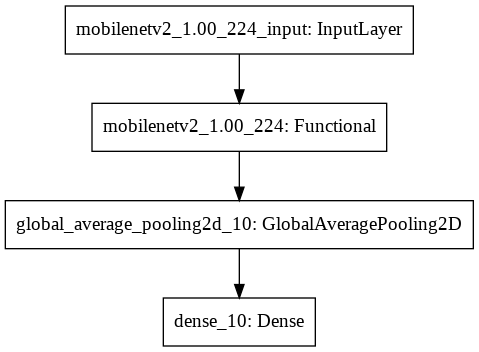

In [70]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')

In [20]:
history = model.fit(l3_X_train, y_train, epochs=10, validation_data=(l3_X_val, y_val)) 

Epoch 1/10
22/22 [==============================] - 45s 2s/step - loss: 0.6157 - accuracy: 0.6296 - val_loss: 0.4512 - val_accuracy: 0.8150
Epoch 2/10
22/22 [==============================] - 42s 2s/step - loss: 0.4413 - accuracy: 0.8060 - val_loss: 0.4171 - val_accuracy: 0.8266
Epoch 3/10
22/22 [==============================] - 42s 2s/step - loss: 0.4138 - accuracy: 0.8283 - val_loss: 0.4315 - val_accuracy: 0.7919
Epoch 4/10
22/22 [==============================] - 41s 2s/step - loss: 0.4481 - accuracy: 0.7976 - val_loss: 0.3973 - val_accuracy: 0.8150
Epoch 5/10
22/22 [==============================] - 41s 2s/step - loss: 0.4181 - accuracy: 0.8037 - val_loss: 0.3833 - val_accuracy: 0.8324
Epoch 6/10
22/22 [==============================] - 42s 2s/step - loss: 0.4021 - accuracy: 0.8124 - val_loss: 0.3694 - val_accuracy: 0.8439
Epoch 7/10
22/22 [==============================] - 41s 2s/step - loss: 0.3905 - accuracy: 0.8330 - val_loss: 0.3596 - val_accuracy: 0.8613
Epoch 8/10
22/22 [==

In [21]:
#save model as checkpoint here 

model.save('my_model_3.h5')

In [10]:
#load the model

model = keras.models.load_model("my_model_3.h5")

In [11]:
#creating heatmaps on test slides 

def generate_heatmap(slide, mask, patch_size, model, level):

  #get the number of patches in the slide 
  num_patches = [slide.level_dimensions[level][0]//patch_size, slide.level_dimensions[level][1]//patch_size]
  ds_factor = 2**level 

  y_test = [] #true values
  preds = []  #predicted values 
  whole_mask = [] 
  whole_slide = [] 

  for i in range(num_patches[0]):
    col_mask_patches = []
    slide_patches = [] 
    for j in range(num_patches[1]):
      #read the patch and then append to slide_patches (idea is to concatenate them into a row of patches)
      patch = read_slide(slide, i*patch_size*ds_factor, j*patch_size*ds_factor, level, patch_size, patch_size)
      slide_patches.append(patch)

      tissue_pixels = find_tissue_pixels(patch)
      percent_tissue = (len(tissue_pixels) / (patch_size * patch_size)) * 100

      mask_patch = read_slide(mask, i*patch_size*ds_factor, j*patch_size*ds_factor, level, patch_size, patch_size)
      mask_patch = mask_patch[:, :, 0]

      #need copy because actual mask is read only 
      mask_copy = np.zeros(mask_patch.shape)

      #only predict on patch if tissue percentage > 25
      if percent_tissue > 25: 
        mask_patch = read_slide(mask, i*patch_size*ds_factor, j*patch_size*ds_factor, level, patch_size, patch_size)

        #reshape to fit into model 
        patch = np.expand_dims(patch, axis=0)

        #get the prediction
        pred_1 = model.predict(patch)

        #final prediction is a probability for each class so have to round 
        final_pred = np.round(pred_1[0][0])
        preds.append(final_pred)

        #get actual answer from mask and add to y_test 
        if np.sum(mask_patch) >= 1: 
          y_test.append(1.0)
        else: 
          y_test.append(0.0)

        #color the mask in if it is predicted to be cancerous 
        if final_pred == 1.0: 
          mask_copy[0:patch_size, 0:patch_size] = 1

      col_mask_patches.append(mask_copy)

    #combine the row mask patches and slide patches 
    col_mask_patches = np.concatenate(col_mask_patches, axis=0)
    slide_patches = np.concatenate(slide_patches, axis = 0)
    whole_mask.append(col_mask_patches) 
    whole_slide.append(slide_patches)

  #combine all the column patches to create the whole mask and whole slide 
  whole_mask = np.concatenate(whole_mask, axis=1)
  whole_slide = np.concatenate(whole_slide, axis=1)
  return whole_slide, whole_mask, y_test, preds  


In [83]:
def get_preds(slide, mask, patch_size, model, level):

  #get the number of patches in the slide 
  num_patches = [slide.level_dimensions[level][0]//patch_size, slide.level_dimensions[level][1]//patch_size]
  ds_factor = 2**level 

  y_test = [] #true values
  preds = []  #predicted values 

  for i in range(num_patches[0]): 
    for j in range(num_patches[1]):
      #read the patch and then append to slide_patches (idea is to concatenate them into a row of patches)
      patch = read_slide(slide, i*patch_size*ds_factor, j*patch_size*ds_factor, level, patch_size, patch_size)

      tissue_pixels = find_tissue_pixels(patch)
      percent_tissue = (len(tissue_pixels) / (patch_size * patch_size)) * 100

      mask_patch = read_slide(mask, i*patch_size*ds_factor, j*patch_size*ds_factor, level, patch_size, patch_size)
      mask_patch = mask_patch[:, :, 0]

      #only predict on patch if tissue percentage > 25
      if percent_tissue > 25: 
        mask_patch = read_slide(mask, i*patch_size*ds_factor, j*patch_size*ds_factor, level, patch_size, patch_size)

        #reshape to fit into model 
        patch = np.expand_dims(patch, axis=0)

        #get the prediction
        pred_1 = model.predict(patch)

        #final prediction is a probability for each class so have to round 
        final_pred = np.round(pred_1[0][0])
        preds.append(final_pred)

        #get actual answer from mask and add to y_test 
        if np.sum(mask_patch) >= 1: 
          y_test.append(1.0)
        else: 
          y_test.append(0.0)

  return y_test, preds  

In [18]:
#return the accuracy given the predicted and true values 
def accuracy(y_test, preds):
  count = 0 
  for i in range(len(y_test)):
    count += int(y_test[i] == preds[i])

  return count/len(y_test)

#return the precision, recall, and confusion matrix given the predicted and true values 
def precision_and_recall(y_test, preds):
  test_df_ratings = pd.DataFrame()
  test_df_ratings['prediction'] = preds
  test_df_ratings['actual'] = y_test

  #find count of true positive, true negative, etc...
  tp = 0
  fp = 0 
  fn = 0 
  tn = 0 
  for i in range(len(test_df_ratings)):
    if (test_df_ratings['actual'][i] == 1) &(test_df_ratings['prediction'][i] == 1):
      tp += 1
    elif (test_df_ratings['actual'][i] == 1) &(test_df_ratings['prediction'][i] == 0):
      fn += 1
    elif (test_df_ratings['actual'][i] == 0) &(test_df_ratings['prediction'][i] == 1):
      fp += 1
    elif (test_df_ratings['actual'][i] == 0) &(test_df_ratings['prediction'][i] == 0):
      tn += 1

  if sum(test_df_ratings['prediction']) == 0: 
    precision = None
  else: 
    precision = tp / sum(test_df_ratings['prediction'])

  recall = tp / sum(test_df_ratings['actual'])

  #build confusion matrix 
  cf_matrix = pd.DataFrame() 
  cf_matrix['Actual_0'] = [tn, fp]
  cf_matrix['Actual_1'] = [fn, tp]

  return precision, recall, cf_matrix

In [85]:
#open the first test slide and test mask 
test_slide_1 = open_slide(slides_folder + "/" + slide_paths[7])
test_mask_1 = open_slide(slides_folder + "/" + mask_paths[7])

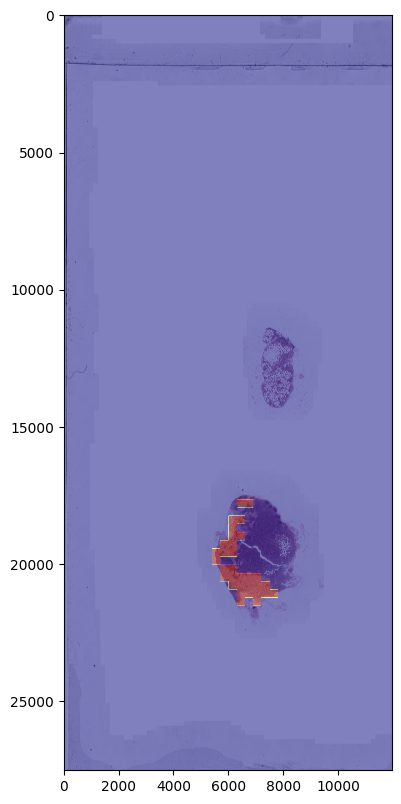

In [86]:
slide_map, mask_heatmap, y_test_ts1, preds_ts1 = generate_heatmap(test_slide_1, test_mask_1, 299, model, 3)

#plot the heatmap 
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_map)
plt.imshow(mask_heatmap, cmap='jet', alpha=0.5) # Red regions contains cancer.

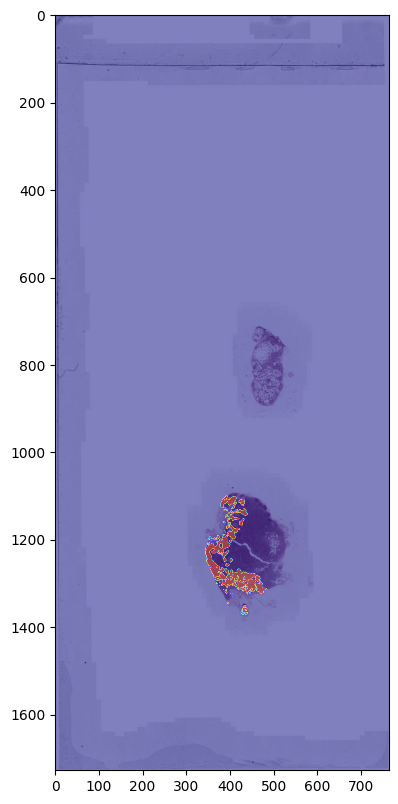

In [87]:
slide_image = read_slide(test_slide_1, 
                         x=0, 
                         y=0, 
                         level=7, 
                         width=test_slide_1.level_dimensions[7][0], 
                         height=test_slide_1.level_dimensions[7][1])


mask_image = read_slide(test_mask_1, 
                        x=0, 
                        y=0, 
                        level=7, 
                        width=test_slide_1.level_dimensions[7][0], 
                        height=test_slide_1.level_dimensions[7][1])

mask_image = mask_image[:,:,0]

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
plt.imshow(mask_image, cmap='jet', alpha=0.5) # Red regions contains cancer.

In [88]:
accuracy_ts_1 = accuracy(y_test_ts1, preds_ts1)
precision_ts_1, recall_ts_1, cf_matrix_ts_1 = precision_and_recall(y_test_ts1, preds_ts1)
print("Accuracy:", accuracy_ts_1)
print() 
print("Precision:", precision_ts_1)
print("Recall:", recall_ts_1)

cf_matrix_ts_1

Accuracy: 0.7847222222222222

Precision: 0.96875
Recall: 0.5081967213114754


,Actual_0,Actual_1
0,82,30
1,1,31


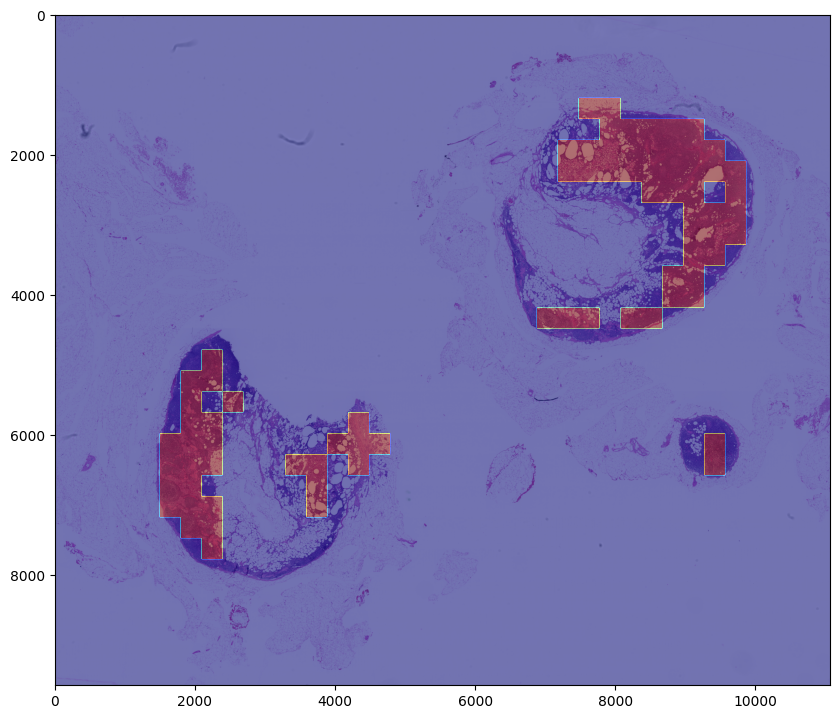

In [16]:
test_slide_3 = open_slide(slides_folder + "/" + slide_paths[12])
test_mask_3 = open_slide(slides_folder + "/" + mask_paths[12])

slide_map, mask_heatmap, y_test_ts3, preds_ts3 = generate_heatmap(test_slide_3, test_mask_3, 299, model, 3)

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_map)
plt.imshow(mask_heatmap, cmap='jet', alpha=0.5) # Red regions contains cancer.

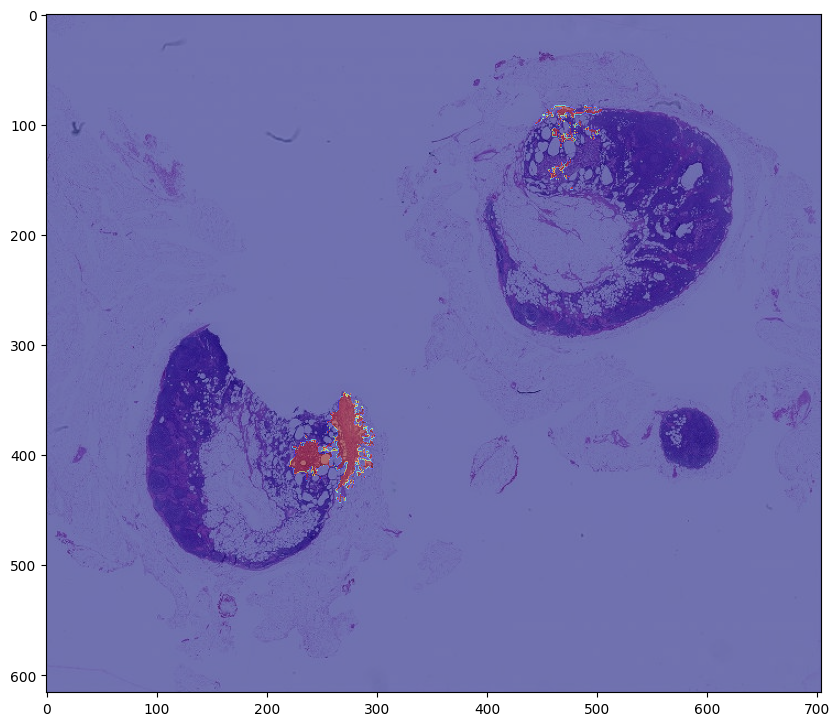

In [15]:
test_slide_3 = open_slide(slides_folder + "/" + slide_paths[12])
test_mask_3 = open_slide(slides_folder + "/" + mask_paths[12])

slide_image = read_slide(test_slide_3, 
                         x=0, 
                         y=0, 
                         level=7, 
                         width=test_slide_3.level_dimensions[7][0], 
                         height=test_slide_3.level_dimensions[7][1])


mask_image = read_slide(test_mask_3, 
                        x=0, 
                        y=0, 
                        level=7, 
                        width=test_slide_3.level_dimensions[7][0], 
                        height=test_slide_3.level_dimensions[7][1])

mask_image = mask_image[:,:,0]

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
plt.imshow(mask_image, cmap='jet', alpha=0.5) # Red regions contains cancer.

In [19]:
accuracy_ts_3 = accuracy(y_test_ts3, preds_ts3)
precision_ts_3, recall_ts_3, cf_matrix_ts_3 = precision_and_recall(y_test_ts3, preds_ts3)
print("Accuracy:", accuracy_ts_3)
print() 
print("Precision:", precision_ts_3)
print("Recall:", recall_ts_3)

cf_matrix_ts_3

Accuracy: 0.5906735751295337

Precision: 0.2077922077922078
Recall: 0.47058823529411764


,Actual_0,Actual_1
0,98,18
1,61,16
